In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Effects of scaling on global feature importance in forecasting machine learning models

## Feature scaling
We can use the two types of feature scaling methods to scale the features:
- Linear scaling like min-max, standard scaling, and robust scaling.
- Non-linear scaling like log, power, root, exponential, box-cox, yeo-johnson, and quantile scaling.

These are the formulas for the different types of scaling:
- Linear scaling: $x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$
- Standard scaling: $x' = \frac{x - \text{mean}(x)}{\text{std}(x)}$
- Robust scaling: $x' = \frac{x - \text{median}(x)}{\text{IQR}(x)}$
- Log scaling: $x' = \log(x)$
- Power scaling: $x' = x^p$
- Root scaling: $x' = \sqrt{x}$
- Exponential scaling: $x' = e^x$
- Box-Cox scaling: $x' = \frac{x^p - 1}{p}$
- Yeo-Johnson scaling: $x' = \begin{cases} \left( x + 1 \right)^p & \text{if } x \geq 0 \\ -\left( -x + 1 \right)^p & \text{if } x < 0 \end{cases}$
- Quantile scaling: $x' = \text{CDF}^{-1}(x)$

where $x$ is the original feature, $x'$ is the scaled feature, $\text{min}(x)$ is the minimum value of $x$, $\text{max}(x)$ is the maximum value of $x$, $\text{mean}(x)$ is the mean value of $x$, $\text{std}(x)$ is the standard deviation of $x$, $\text{median}(x)$ is the median value of $x$, $\text{IQR}(x)$ is the interquartile range of $x$, $p$ is the power parameter, and $\text{CDF}^{-1}(x)$ is the inverse cumulative distribution function of $x$.


### Goal
Evaluate the effects of scaling on global feature importance in forecasting machine learning models.


## Datasets:
- Linear dataset: [Ref](data\linear_dep_time_series.csv)
- Non-linear dataset: [Ref](data\nonlinear_time_series.csv)

,date,s_1,s_2,s_3,holiday,weather
0,2023-01-01,50.000000,150.000000,300.000000,0,31.852103
1,2023-01-02,100.000000,200.000000,350.000000,1,13.299608
2,2023-01-03,100.609331,195.258758,368.269784,0,29.497161
3,2023-01-04,99.437613,165.805578,351.979250,0,16.390125
4,2023-01-05,98.066940,176.120203,369.788392,0,16.449677


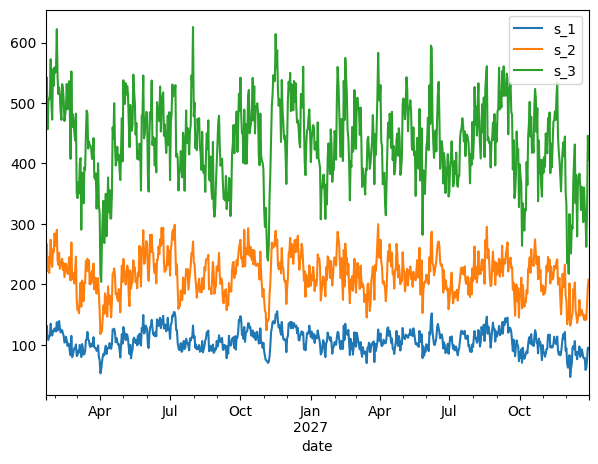

In [2]:
import pandas as pd

df_lin = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df_lin["date"] = pd.to_datetime(df_lin["date"])
df_lin.set_index("date")[series][-710:].plot(figsize=(7, 5))
display(df_lin.head())




,series,date,white_noise,series_seasonal_trend_factor,weekend_trend_factor,holiday_trend_factor,total_factor,value,day_of_year
0,s_3,2019-01-01,0.933390,0.604529,1.0,1.5,1.692784,169.278352,1
1,s_2,2019-01-01,0.946402,0.703397,1.0,1.5,0.998544,99.854437,1
2,s_1,2019-01-01,0.964324,0.802264,1.0,1.5,0.580232,58.023197,1
3,s_3,2019-01-02,0.994360,0.603554,1.0,1.5,1.800451,180.045086,2
4,s_2,2019-01-02,0.903683,0.702666,1.0,1.5,0.952481,95.248114,2


<Axes: xlabel='date'>

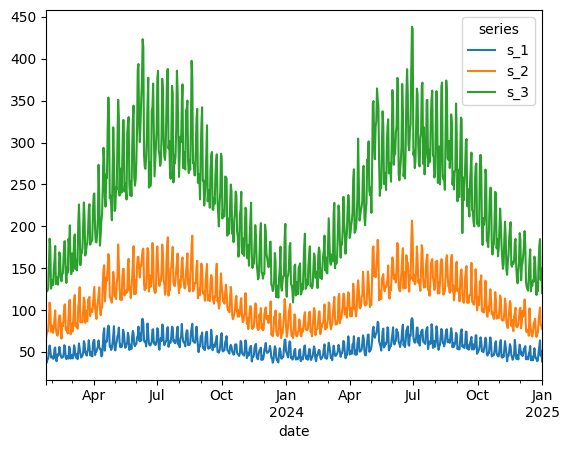

In [3]:
df_nonlin = pd.read_csv("data\\non_linear_time_series.csv", index_col=1)

df_nonlin.reset_index( inplace=True)
df_nonlin["date"] = pd.to_datetime(df_nonlin["date"])
series = ["s_1", "s_2", "s_3"]
display(df_nonlin.head())

df_nonlin.pivot(columns="series", values="value", index="date")[-710:].plot(legend=True)

## Preprocessing of datasets

Preprocesing steps:
- Split the series from the exogenous features.
- Transform to long format 
- Split the data into training and test sets.


C:\Users\Matty\AppData\Local\Temp\ipykernel_9572\991658549.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2027-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=364)


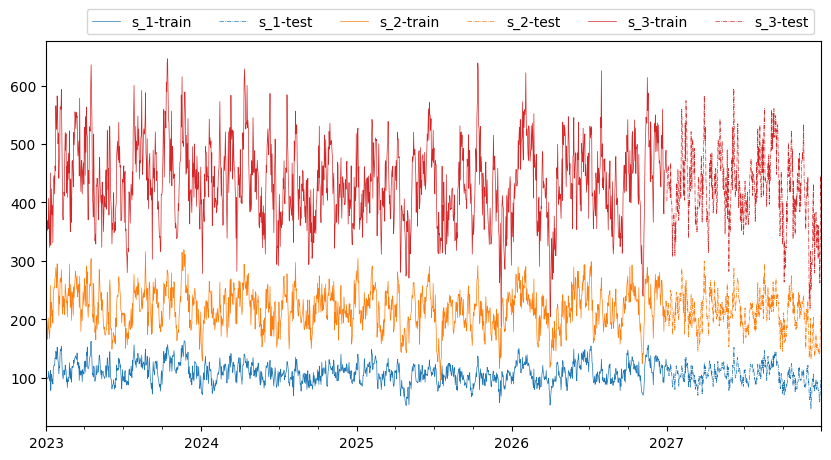

In [4]:
## Prepare linear combined data
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold


df_lin["date"] = pd.to_datetime(df_lin["date"])

# melt the series and prepare for the model
df_demand = df_lin.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df_lin[["date", "holiday", "weather"]].drop_duplicates()


#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
#df_exog["holiday"] = df_exog["holiday"].astype(bool)
df_exog["holiday"] = df_exog["holiday"].astype(int)


df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

# define split date
split_date = "2026-12-31"


lin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
lin_dataset.show_sizes()
lin_dataset.plot_series()

C:\Users\Matty\AppData\Local\Temp\ipykernel_9572\1800552341.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])
C:\Users\Matty\AppData\Local\Temp\ipykernel_9572\1800552341.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


<class 'pandas.core.frame.DataFrame'>
Index: 6579 entries, 0 to 6576
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  6579 non-null   datetime64[ns]
 1   weekend_trend_factor  6579 non-null   float64       
 2   holiday_trend_factor  6579 non-null   float64       
 3   day_of_year           6579 non-null   int64         
 4   series_id             6579 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 308.4+ KB
Dataset dates      : (Timestamp('2019-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))  (n=2193)
Train dates      : (Timestamp('2019-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))  (n=1826)
Test dates      : (Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))  (n=367)


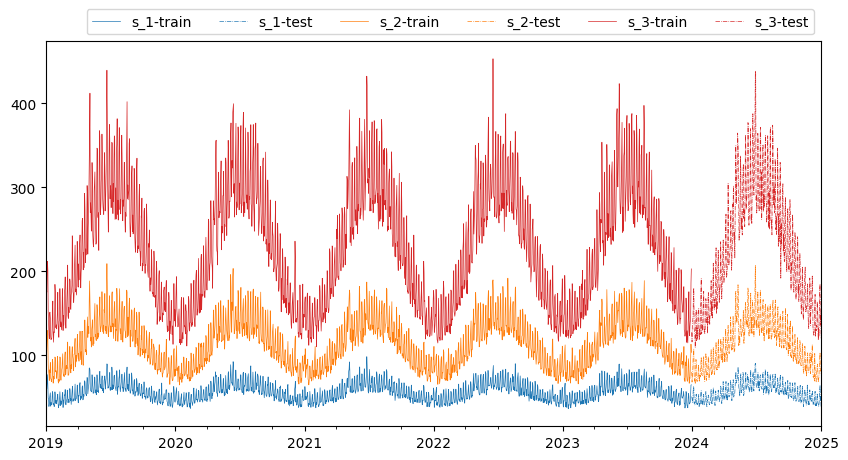

In [5]:
# melt the series and prepare for the model

df_demand = df_nonlin[["date", "series", "value"]].copy()
df_demand["series_id"] = df_demand["series"]
# create exog dataframe for holiday and	weather
df_exog_temp = df_nonlin[
    ["date", "weekend_trend_factor", "holiday_trend_factor", "day_of_year"]
].drop_duplicates()

# replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
df_exog["series_id"] = ""
for s in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = s
    df_exog = pd.concat([df_exog, df_exog_brand])


# replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)

df_exog["day_of_year"] = df_exog["day_of_year"].astype(int)
df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])
df_exog.info()
# define split date

split_date = "2023-12-31"
mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

nonlin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
nonlin_dataset.show_sizes()
nonlin_dataset.plot_series()

## Train and explain the models

Train the models:
- LigthGBM model
- Random Forest model ??

Importance metrics:
- SHAP values - Tree explainer, Kernel explainer
- Permutation feature importance - Mean average error (MAE) 

With and without scaling the features.

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1307
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start training from score 0.349317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start training from score 0.371157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start training 

(              0
 MAE    5.986197
 MSE   77.683622
 R2     0.988890
 MAPE   0.045228,
            MAE         MSE        R2      MAPE
 s_1   2.530089   10.554861  0.917286  0.045266
 s_2   4.709183   37.069189  0.954837  0.041940
 s_3  10.719320  185.426815  0.964708  0.048480)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start training from score 131.942374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start training from score 132.602763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 8
[LightGBM] [Info] Start train

(              0
 MAE    6.110672
 MSE   82.640525
 R2     0.988181
 MAPE   0.045690,
            MAE         MSE        R2      MAPE
 s_1   2.444873    9.679770  0.924144  0.043845
 s_2   5.073358   41.467899  0.949477  0.045009
 s_3  10.813785  196.773906  0.962548  0.048216)

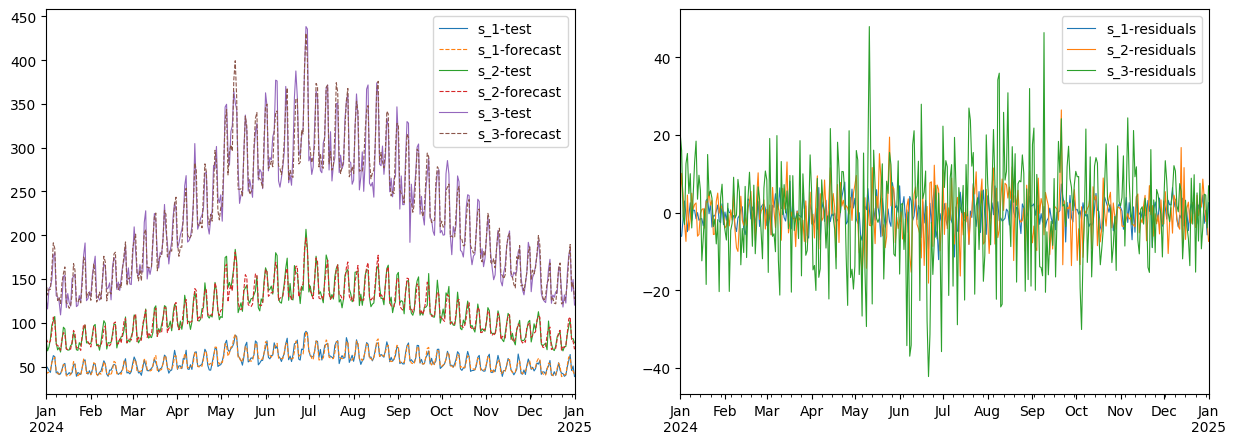

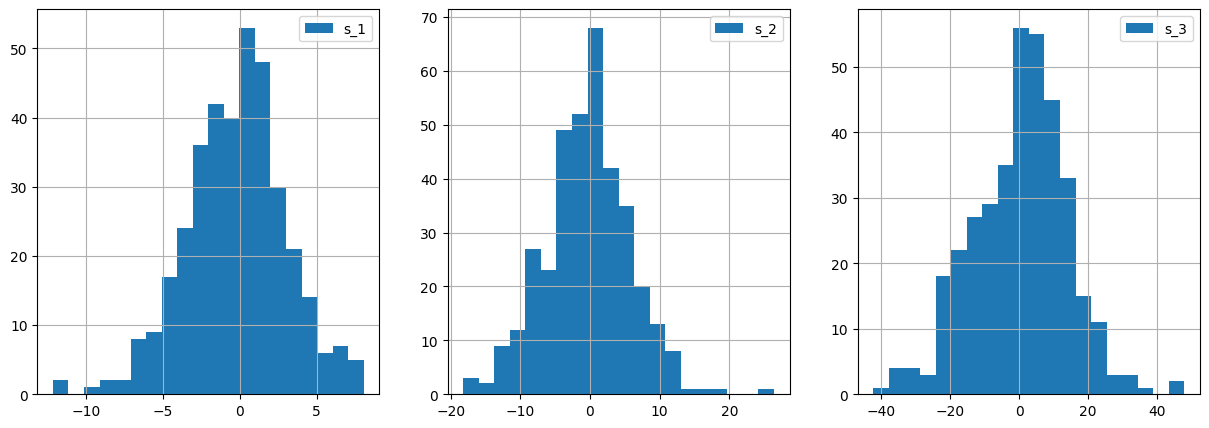

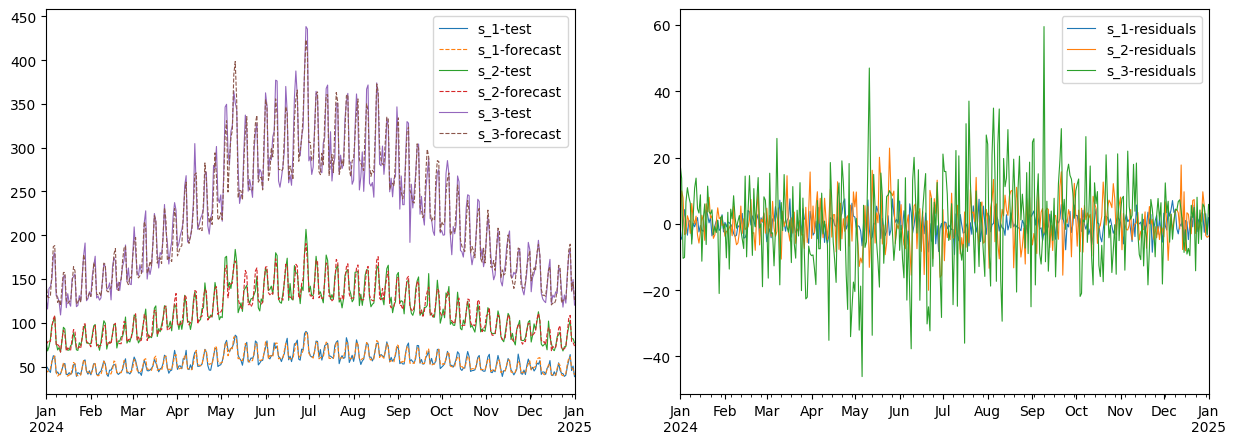

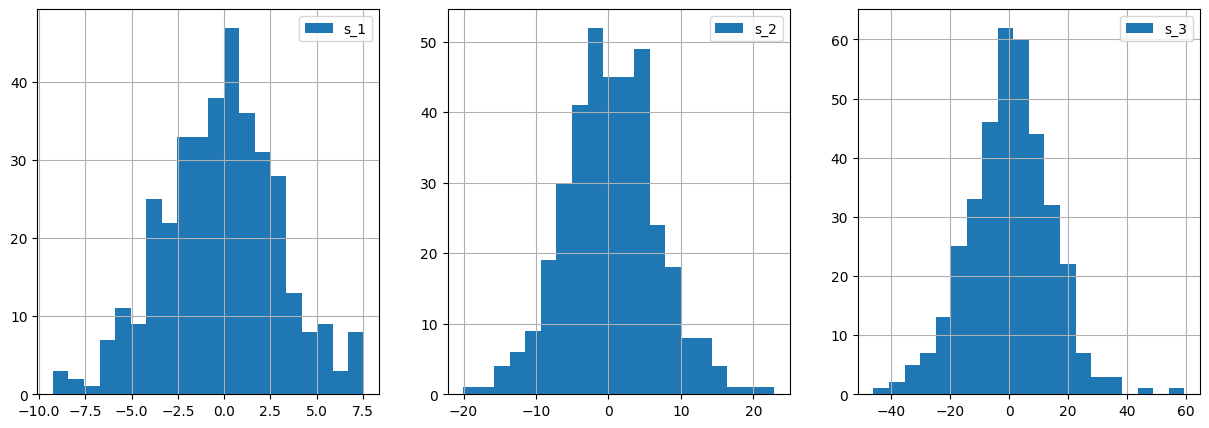

In [ ]:
# forecast linear
# 
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]), # [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }


regressor:LGBMRegressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_scaled = ForecasterMsExog( 
    data = nonlin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
display(forecaster_scaled.calculate_test_performance_metrics())
forecaster_scaled.plot_forecast()


r1regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_nonscaled = ForecasterMsExog( 
    data = nonlin_dataset,
    regressor=r1regressor,
    scale=None
    # search_space=search_space,
)
t2 = forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

forecaster_nonscaled.plot_forecast()


display(forecaster_nonscaled.calculate_test_performance_metrics())


In [ ]:
from tsxp.forecaster import ForecasterMsExog

from sklearn.ensemble import RandomForestRegressor

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]), #[3,4, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }

regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_scaled = ForecasterMsExog( 
    data = nonlin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = rf_forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_scaled.plot_forecast()
display(rf_forecaster_scaled.calculate_test_performance_metrics())
######### Not scaled
regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_nonscaled = ForecasterMsExog( 
    data = nonlin_dataset,
    regressor=regressor,
    scale=None
    # search_space=search_space,
)
t2 = rf_forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_nonscaled.plot_forecast()
display(rf_forecaster_nonscaled.calculate_test_performance_metrics())

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 892}
  Backtesting metric: 11.48069041425054
  Levels: ['s_1', 's_2', 's_3']



(              0
 MAE    5.658153
 MSE   71.119965
 R2     0.989828
 MAPE   0.042971,
           MAE         MSE        R2      MAPE
 s_1  2.429637    9.568937  0.925012  0.043319
 s_2  4.635506   36.066247  0.956058  0.040963
 s_3  9.909314  167.724710  0.968077  0.044631)

  0%|          | 0/10 [00:00<?, ?it/s]

### Model training summary

On test set the models achieve 0.97 ~R^2 score which makes sense given that the generated data has added noise.

## Feature importance calculation

Metrics calculated:
- Tree SHAP values: train and test 
- Kernel SHAP values: train and test
- PFI: ---
- Tree gain: both for LightGBM and Random Forest
- Tree split: for LightGBM

Features are also ranked and relative importance is also calculated. 

Shap is calculated for each model and dataset.

Calculating fast TreeSHAP values with perturbation: interventional


 99%|===================| 5393/5466 [01:13<00:00]        

Calculating fast TreeSHAP values with perturbation: interventional


 99%|===================| 1090/1101 [00:13<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TRAIN,TREE_SHAP_TEST,TREE_PATH_SHAP
weekend_trend_factor,0.019718,0.019746,0.516561,0.505873,171.428160,376,0.091786,0.089233,0.080639
day_of_year,0.010849,0.010442,0.284215,0.267522,36.296601,2577,0.059371,0.059012,0.037363
lag_1,0.010713,0.010194,0.280666,0.261164,712.142052,2801,0.056015,0.055201,0.089429
lag_4,0.002861,0.002256,0.074945,0.057791,80.141082,2847,0.022681,0.023837,0.022834
holiday_trend_factor,0.001618,0.001561,0.042380,0.039997,13.239521,568,0.013647,0.015693,0.013441
_level_skforecast,0.001324,0.001124,0.034699,0.028809,11.005318,670,0.008201,0.007853,0.008281
lag_3,0.001270,0.000717,0.033276,0.018378,49.042312,2590,0.011200,0.010296,0.010536
lag_2,0.000848,0.000294,0.022228,0.007538,13.342068,2511,0.007410,0.007519,0.006534


Rank                                            \
                     PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
weekend_trend_factor       1            1      1           1         2   
day_of_year                2            2      2           2         5   
lag_1                      3            3      3           3         1   
lag_4                      4            4      4           4         3   
holiday_trend_factor       5            5      5           5         7   
_level_skforecast          6            6      6           6         8   
lag_3                      7            7      7           7         4   
lag_2                      8            8      8           8         6   

                                                                               
                     TREE_SPLIT TREE_SHAP_TRAIN TREE_SHAP_TEST TREE_PATH_SHAP  
weekend_trend_factor          8               1              1              2  
day_of_year                   4               2              2              3  
lag_1                         2               3              3              1  
lag_4                         1               4              4              4  
holiday_trend_factor          7               5              5              5  
_level_skforecast             6               7              7              7  
lag_3                         3               6              6              6  
lag_2                         5               8              8              8

Perc                                      \
                        PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST   
weekend_trend_factor  40.075477    42.615173  40.075477   42.615173   
day_of_year           22.049742    22.536301  22.049742   22.536301   
lag_1                 21.774419    22.000690  21.774419   22.000690   
lag_4                  5.814353     4.868375   5.814353    4.868375   
holiday_trend_factor   3.287887     3.369358   3.287887    3.369358   
_level_skforecast      2.692014     2.426913   2.692014    2.426913   
lag_3                  2.581624     1.548142   2.581624    1.548142   
lag_2                  1.724483     0.635049   1.724483    0.635049   

                                                                           \
                      TREE_GAIN TREE_SPLIT TREE_SHAP_TRAIN TREE_SHAP_TEST   
weekend_trend_factor  15.776027   2.516734       33.955697      33.215939   
day_of_year            3.340269  17.248996       21.963718      21.966636   
lag_1                 65.536327  18.748327       20.722420      20.547837   
lag_4                  7.375147  19.056225        8.390852       8.873213   
holiday_trend_factor   1.218394   3.801874        5.048777       5.841706   
_level_skforecast      1.012787   4.484605        3.033954       2.923245   
lag_3                  4.513219  17.336011        4.143263       3.832581   
lag_2                  1.227831  16.807229        2.741318       2.798844   

                                     
                     TREE_PATH_SHAP  
weekend_trend_factor      29.970919  
day_of_year               13.886709  
lag_1                     33.237859  
lag_4                      8.486804  
holiday_trend_factor       4.995444  
_level_skforecast          3.077805  
lag_3                      3.916067  
lag_2                      2.428392

 94%|=================== | 1039/1101 [00:15<00:00]       

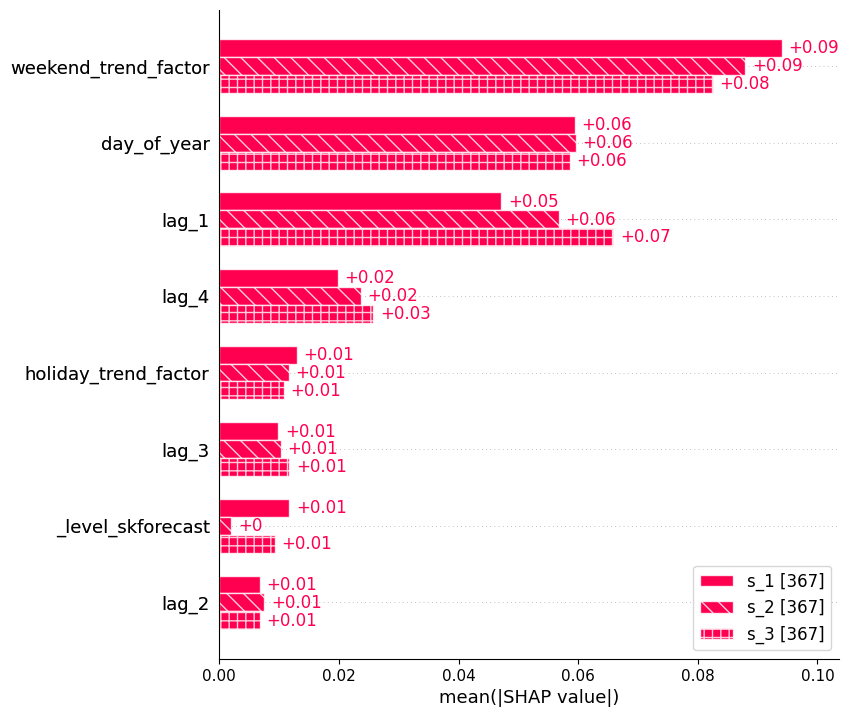

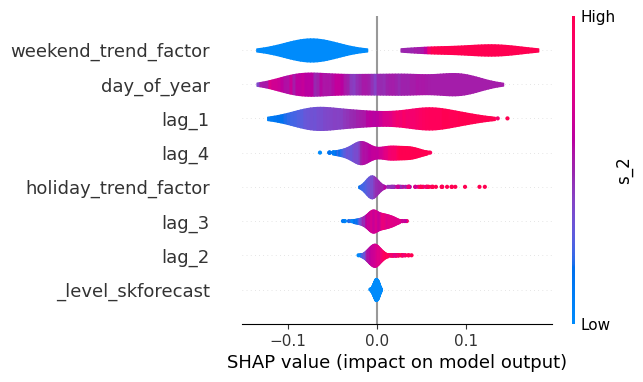

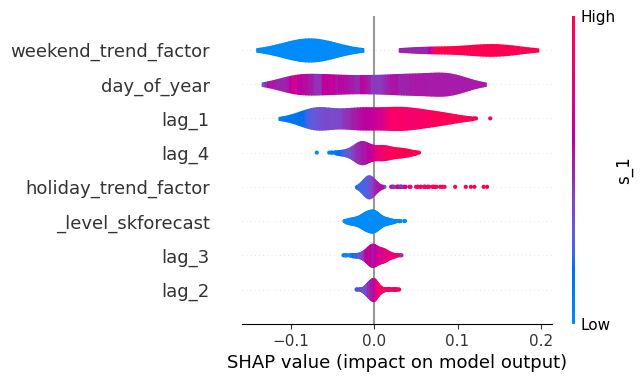

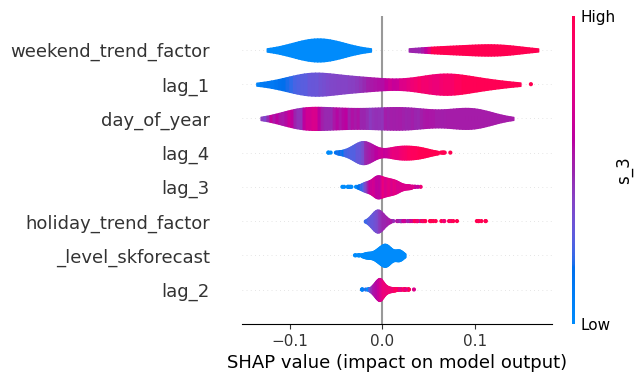

Calculating fast TreeSHAP values with perturbation: interventional


100%|===================| 5448/5466 [01:21<00:00]        

Calculating fast TreeSHAP values with perturbation: interventional


100%|===================| 1100/1101 [00:18<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TRAIN,TREE_SHAP_TEST,TREE_PATH_SHAP
lag_1,5683.478657,5605.672493,0.809351,0.801736,1.851218e+08,3234,39.186781,40.716398,49.224601
weekend_trend_factor,706.309467,714.146303,0.100581,0.102139,6.528570e+06,521,14.875098,15.452375,14.052370
lag_4,293.410897,266.344411,0.041783,0.038093,3.650205e+06,3094,7.531081,7.778852,5.709557
_level_skforecast,272.186043,268.569089,0.038760,0.038411,2.640784e+06,192,9.346523,9.170322,7.445181
day_of_year,245.387635,217.762816,0.034944,0.031145,1.201043e+06,2928,5.637031,5.711425,4.559315
lag_3,78.711255,57.082260,0.011209,0.008164,1.393462e+06,2697,4.370752,3.885327,2.910433
lag_2,61.351752,37.691342,0.008737,0.005391,6.024928e+05,2819,3.105880,3.077995,2.229564
holiday_trend_factor,60.882275,62.823879,0.008670,0.008985,4.758509e+05,655,2.381846,2.513581,2.122679


Rank                                            \
                     PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
lag_1                      1            1      1           1         1   
weekend_trend_factor       2            2      2           2         2   
lag_4                      3            4      3           4         3   
_level_skforecast          4            3      4           3         4   
day_of_year                5            5      5           5         6   
lag_3                      6            7      6           7         5   
lag_2                      7            8      7           8         7   
holiday_trend_factor       8            6      8           6         8   

                                                                               
                     TREE_SPLIT TREE_SHAP_TRAIN TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1                         1               1              1              1  
weekend_trend_factor          7               2              2              2  
lag_4                         2               4              4              4  
_level_skforecast             8               3              3              3  
day_of_year                   3               5              5              5  
lag_3                         5               6              6              6  
lag_2                         4               7              7              7  
holiday_trend_factor          6               8              8              8

Perc                                      \
                        PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST   
lag_1                 76.785939    77.532513  76.785939   77.532513   
weekend_trend_factor   9.542507     9.877416   9.542507    9.877416   
lag_4                  3.964092     3.683831   3.964092    3.683831   
_level_skforecast      3.677336     3.714601   3.677336    3.714601   
day_of_year            3.315279     3.011895   3.315279    3.011895   
lag_3                  1.063419     0.789509   1.063419    0.789509   
lag_2                  0.828885     0.521312   0.828885    0.521312   
holiday_trend_factor   0.822542     0.868922   0.822542    0.868922   

                                                                           \
                      TREE_GAIN TREE_SPLIT TREE_SHAP_TRAIN TREE_SHAP_TEST   
lag_1                 91.819820  20.037175       45.336708      46.108159   
weekend_trend_factor   3.238149   3.228005       17.209579      17.498615   
lag_4                  1.810490  19.169765        8.713001       8.808946   
_level_skforecast      1.309820   1.189591       10.813356      10.384678   
day_of_year            0.595713  18.141264        6.521700       6.467745   
lag_3                  0.691153  16.710037        5.056693       4.399831   
lag_2                  0.298834  17.465923        3.593313       3.485591   
holiday_trend_factor   0.236021   4.058240        2.755650       2.846436   

                                     
                     TREE_PATH_SHAP  
lag_1                     55.776246  
weekend_trend_factor      15.922697  
lag_4                      6.469482  
_level_skforecast          8.436112  
day_of_year                5.166146  
lag_3                      3.297803  
lag_2                      2.526312  
holiday_trend_factor       2.405201

 94%|=================== | 1035/1101 [00:14<00:00]       

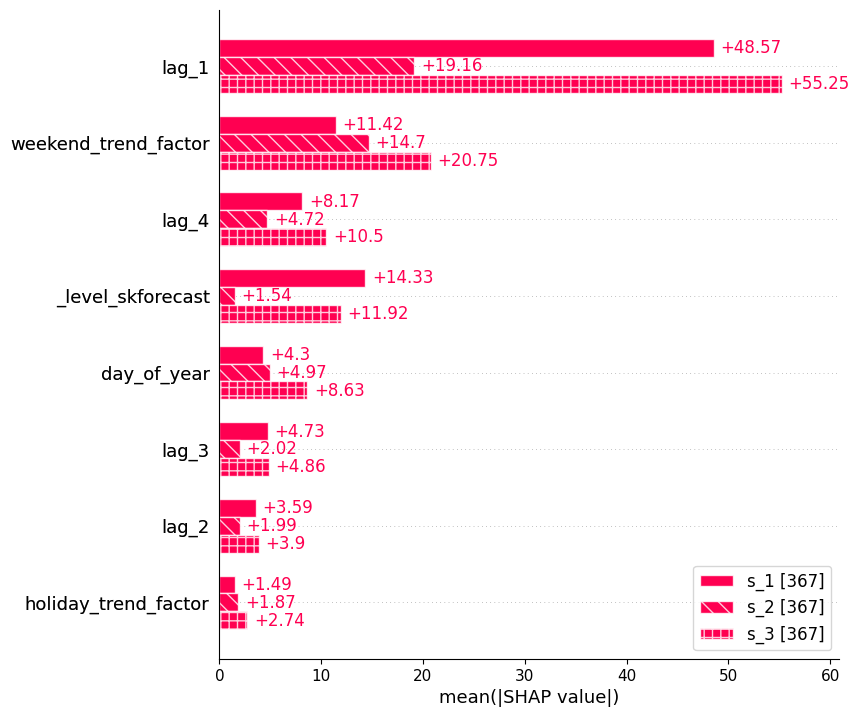

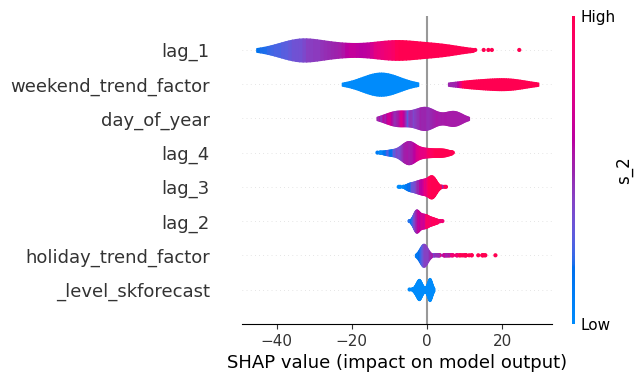

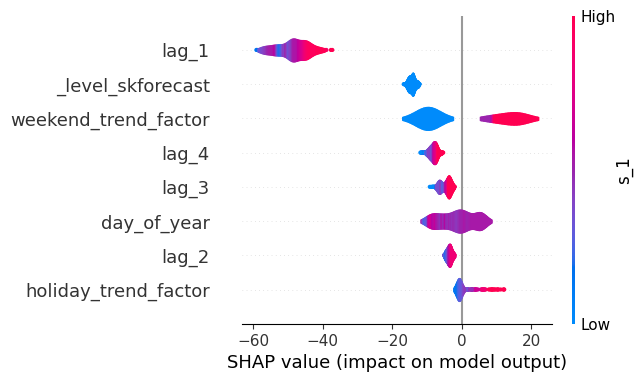

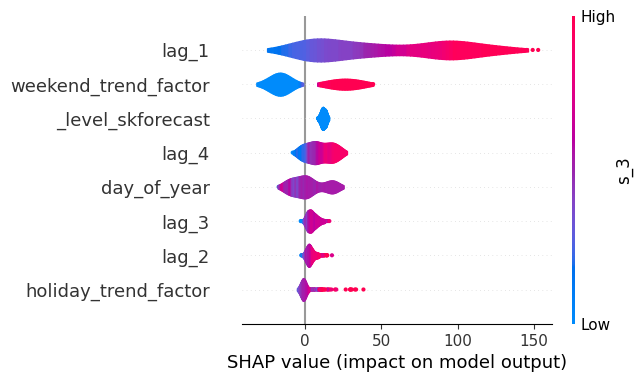

Calculating fast TreeSHAP values with perturbation: interventional


100%|===================| 5468/5469 [41:03<00:00]        

Calculating fast TreeSHAP values with perturbation: interventional


100%|===================| 1100/1101 [08:02<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [9]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    "lgbm_scaled": forecaster_scaled,
    "lgbm_nonscaled": forecaster_nonscaled,
    "rf_forecaster_scaled": rf_forecaster_scaled,
    "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}

explainers = {}

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    fi_explainer.plot_importance_for_series()

# fi_explainer = ForecasterMsExogFeatureImportance(forecaster_scaled)

# for name, explainer in explainers.items():
#     display(HTML(data="<h1> Importances: "+name+"<h1/>"))
#     # explainer.calculate_feature_importance()
#     display(explainer.feature_importance)
#     display(explainer.feature_rank)
#     display(explainer.relative_feature_importance)
#     explainer.plot_importance_for_series()


In [16]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    # "lgbm_scaled": forecaster_scaled,
    # "lgbm_nonscaled": forecaster_nonscaled,
    "rf_forecaster_scaled": rf_forecaster_scaled,
    "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}

explainers = {}

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    # fi_explainer.plot_importance_for_series()


KeyboardInterrupt: 